This notebook is a short guide that covers issues of interest including:
1. Defining and solving SDEs
1. Gaining control over the randomness (path generation conditional on a Brownian motion sample)
1. Different noise types of SDEs
1. Gradient computation/backpropagation

In [1]:
import torch
from torch import nn

import os
import sys
module_path = os.path.abspath(os.path.join('..'))
if module_path not in sys.path:
    sys.path.append(module_path)

%matplotlib inline
import matplotlib.pyplot as plt

import torchsde

def plot(ts, samples, xlabel, ylabel, title=''):
    ts = ts.cpu()
    samples = samples.squeeze().t().cpu()
    plt.figure()
    for i, sample in enumerate(samples):
        plt.plot(ts, sample, marker='x', label=f'sample {i}')
    plt.title(title)
    plt.xlabel(xlabel)
    plt.ylabel(ylabel)
    plt.legend()
    plt.show()

Just like how each ordinary differential equation (ODE) is governed by a vector field, a stochastic differential equation (SDE) is governed by two vector fields, which are called the **drift** and **diffusion** functions:
$$dy(t) = \underbrace{f(t, y(t), \theta_f)}_{\text{drift}} dt + \underbrace{g(t, y(t), \theta_g)}_{\text{diffusion}} dW(t).$$
The output of $f$ is of the same size as the $d$-dimensional state, whereas the output of $g$ may be a matrix of size $(d, m)$. $W(t)$ is the Brownian motion (aka Wiener process), and it is $m$ dimensional. It is a stochastic process, and each random draw produces a function of time. 

Note that the second term on the right hand side $gdW$ is based on matrix-vector products.

### 1. Solving a simple SDE
To implement an SDE, we create a class with the functions _`f`_ and _`g`_:

In [2]:
class SDE(nn.Module):

    def __init__(self):
        super().__init__()
        self.theta = nn.Parameter(torch.tensor(0.1), requires_grad=True)  # Scalar parameter.
        self.noise_type = "diagonal"
        self.sde_type = "ito"
    
    def f(self, t, y):
        return torch.sin(t) + self.theta * y
    
    def g(self, t, y):
        return 0.3 * torch.sigmoid(torch.cos(t) * torch.exp(-y))

The functions _`f`_ and _`g`_ are arbitrarily chosen for demonstration purposes. The attributes _`noise_type`_ and _`sde_type`_ must be included to inform the solver about how to interpret the SDE, and determine which numerical methods are available. See [below](#noise_type) for more detail on how the output of g depends on the different noise types.

We use _`diagonal`_ here, meaning the output of _`g`_ should be a vector with the same shape as input _`y`_, and it is an element-wise function.
Note that for any other noise type, we expect the output of _`g`_ to be a matrix, and a batch matrix-vector product will be performed with the Brownian motion.

The codebase supports both Itô SDEs based on [Itô integrals](https://en.wikipedia.org/wiki/It%C3%B4_calculus) and Stratonovich SDEs based on [Stratonovich integrals](https://en.wikipedia.org/wiki/Stratonovich_integral).

Now we instantiate an object of the SDE class and call the function _`sdeint`_ on it.

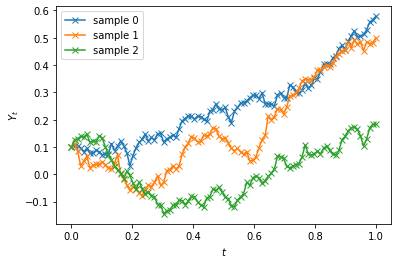

In [3]:
batch_size, state_size, t_size = 3, 1, 100
sde = SDE()
ts = torch.linspace(0, 1, t_size)
y0 = torch.full(size=(batch_size, state_size), fill_value=0.1)

with torch.no_grad():
    ys = torchsde.sdeint(sde, y0, ts, method='euler')  # (t_size, batch_size, state_size) = (100, 3, 1).

plot(ts, ys, xlabel='$t$', ylabel='$Y_t$')

For _Itô_ SDEs _`method='euler'`_ means the strong order 0.5 _Euler-Maruyama_ method is used. Other possible methods include the strong order 1.0 _`milstein`_ and the strong order 1.5 _`srk`_, both of which are of slightly higher order. If _`method`_ is set to `None`, an appropriate solver would be chosen based on _`noise_type`_ and _`sde_type`_ under the hood.

To solve a Stratonovich SDE with drift and diffusion defined above, we need only change _`sde_type`_ to _`stratonovich`_ and supply an appropriate method of choice (e.g. the _`midpoint`_ method):

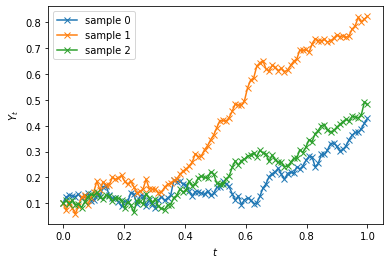

In [4]:
sde.sde_type = "stratonovich"

with torch.no_grad():
    ys = torchsde.sdeint(sde, y0, ts, method="midpoint")  # (t_size, batch_size, state_size) = (100, 3, 1).

plot(ts, ys, xlabel='$t$', ylabel='$Y_t$')

For _Stratonovich_ SDEs, the methods _`midpoint`_, _`euler_heun`_, _`heun`_, _`milstein`_, and _`log_ode`_ are supported. 

The drift and diffusion functions don't necessarily have to be called _`f`_ and _`g`_. They can be methods with any name, so long as we provide these names to the solver when they differ from the default. The following is an example where _`h`_ is used as the drift.

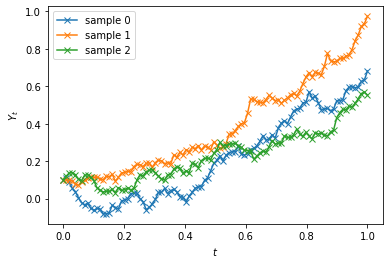

In [5]:
class SDENewName(nn.Module):

    def __init__(self):
        super().__init__()
        self.theta = nn.Parameter(torch.tensor(0.1), requires_grad=False)  # Scalar parameter.
        self.noise_type = "diagonal"
        self.sde_type = "ito"
    
    def h(self, t, y):
        return torch.sin(t) + self.theta * y
    
    def g(self, t, y):
        return 0.3 * torch.sigmoid(torch.cos(t) * torch.exp(-y))
    
sde_new_name = SDENewName()

with torch.no_grad():
    # Supply a dictionary to the argument `names`.
    ys = torchsde.sdeint(sde_new_name, y0, ts, method='euler', names={'drift': 'h'})

plot(ts, ys, xlabel='$t$', ylabel='$Y_t$')

Trivially, the previous code may be adapted to run on GPUs, just by moving all tensors to a GPU:

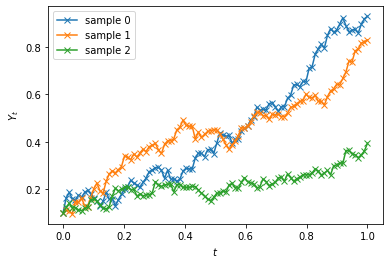

In [6]:
if torch.cuda.is_available():
    gpu = torch.device('cuda')
    sde = SDE().to(gpu)
    ts = ts.to(gpu)
    y0 = y0.to(gpu)
    with torch.no_grad():
        ys = torchsde.sdeint(sde, y0, ts, method='euler')  # (100, 3, 1).
    
    plot(ts, ys, xlabel='$t$', ylabel='$Y_t$')

A side note is that multi-GPU data parallel is possible with the existing codebase, but the use case has not been tested out extensively and may require defining non-standard SDE classes and methods. 

### 2. Explicit control over randomness from the Brownian motion
To gain control over the randomness, we draw Brownian motion samples by instantiating objects of classes `BrownianInterval`.

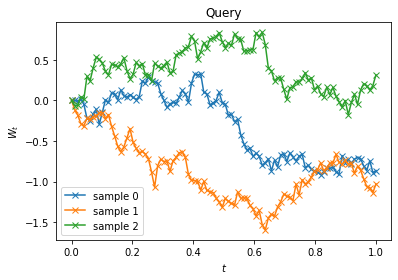

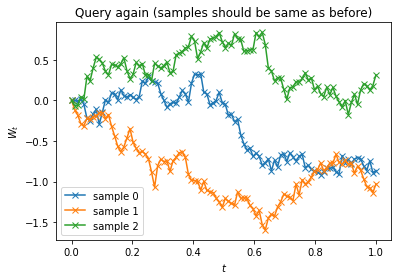

In [7]:
ts = torch.linspace(0, 1, t_size)
bm = torchsde.BrownianInterval(t0=0.0, t1=1.0, size=(batch_size, state_size))

bm_increments = torch.stack([bm(t0, t1) for t0, t1 in zip(ts[:-1], ts[1:])], dim=0)
bm_queries = torch.cat((torch.zeros(1, batch_size, state_size), torch.cumsum(bm_increments, dim=0)))
plot(ts, bm_queries, xlabel='$t$', ylabel='$W_t$', title='Query')

bm_increments2 = torch.stack([bm(t0, t1) for t0, t1 in zip(ts[:-1], ts[1:])], dim=0)
bm_queries2 = torch.cat((torch.zeros(1, batch_size, state_size), torch.cumsum(bm_increments2, dim=0)))
plot(ts, bm_queries2, xlabel='$t$', ylabel='$W_t$', 
     title='Query again (samples should be same as before)')

assert torch.allclose(bm_queries, bm_queries2)

We can also create the Brownian motion on GPUs by specifying `device`:

In [8]:
if torch.cuda.is_available():
    bm = torchsde.BrownianInterval(t0=0.0, t1=1.0, size=(batch_size, state_size), device=gpu)
    print(bm(0.0, 0.5))

tensor([[-0.1655],
        [ 0.4335],
        [-0.6226]], device='cuda:0')


Having a Brownian motion object helps us gain control over the randomness better. We can feed the object into the solver such that the solver's solution is conditioned on this path. 

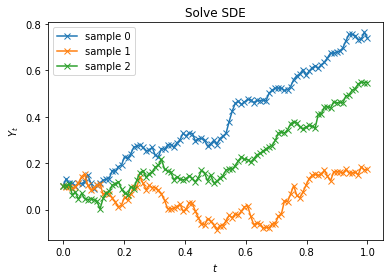

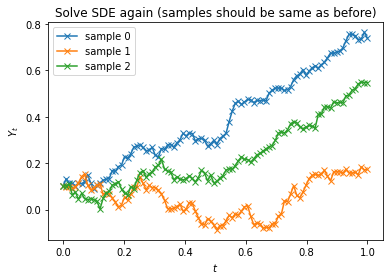

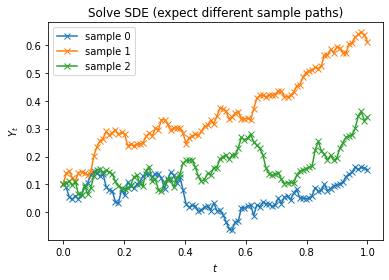

In [9]:
sde = SDE()
ts = torch.linspace(0, 1, t_size)
y0 = torch.zeros((batch_size, 1)).fill_(0.1)  # (batch_size, state_size).
bm = torchsde.BrownianInterval(t0=0.0, t1=1.0, size=(batch_size, state_size))

with torch.no_grad():
    ys = torchsde.sdeint(sde, y0, ts, method='milstein', bm=bm)
plot(ts, ys, xlabel='$t$', ylabel='$Y_t$', title='Solve SDE')

with torch.no_grad():
    ys = torchsde.sdeint(sde, y0, ts, method='milstein', bm=bm)
plot(ts, ys, xlabel='$t$', ylabel='$Y_t$', 
     title='Solve SDE again (samples should be same as before)')

# Use a new BM sample, we expect different sample paths.
bm = torchsde.BrownianInterval(t0=0.0, t1=1.0, size=(batch_size, state_size))
with torch.no_grad():
    ys = torchsde.sdeint(sde, y0, ts, method='milstein', bm=bm)
plot(ts, ys, xlabel='$t$', ylabel='$Y_t$', 
     title='Solve SDE (expect different sample paths)')

### 3. Noise type of SDEs affects which solvers can be used and what strong orders can be attained<a id='noise_type'></a> 

The supported noise types of this codebase are "_diagonal_", "_additive_", "_scalar_", and "_general_".
The following is a simple summary of each type:
- "_diagonal_": The diffusion function is an elementwise function, whose output has the same size as that of the state (both are of size `(batch_size, state_size)`). There are _`state_size`_ independent Brownian motions, each responsible for the noise of only a single state dimension.
- "_additive_": The diffusion function is constant w.r.t. the state (but not necessarily time). The output of the diffusion function is of size `(batch_size, state_size, brownian_size)`, and the system has _`brownian_size`_ independent Brownian motions. The integral involving the Brownian motion can be loosely interpreted as integrating a sequence of matrix-vector products.
- "_scalar_": The diffusion function has output shape `(batch_size, state_size, 1)`, and a single Brownian motion is shared across all state dimensions. 
- "_general_": The diffusion function has output shape `(batch_size, state_size, brownian_size)`, and the system has _`brownian_size`_ independent Brownian motions.

It is tempting to use the noise type configuration "_general_" for all problems. However, since there's little known structure for these SDEs, solvers with high strong-order cannot be constructed.

Lastly, for modeling problems, our limited experience have found "_diagonal_" to be a good setting, where flexibility of models and tractability of numerical integration is rather well-balanced.


### 4. Computing gradients

Computing gradients through SDE solutions can be easily done by calling the `backward` function on loss tensors, or using `torch.autograd.grad`:

In [10]:
ys = torchsde.sdeint(sde, y0, ts, method='euler', bm=bm)
y_final = ys[-1]
target = torch.randn_like(y_final)
loss = ((target - y_final) ** 2).sum(dim=1).mean(dim=0)
loss.backward()
print(sde.theta.grad)

tensor(0.7085)


In [11]:
ys = torchsde.sdeint(sde, y0, ts, method='euler', bm=bm)
y_final = ys[-1]
target = torch.randn_like(y_final)
loss = ((target - y_final) ** 2).sum(dim=1).mean(dim=0)
grad, = torch.autograd.grad(loss, sde.theta)
print(grad)

tensor(0.0075)


Switching to adjoint-mode gradient computation is as simple as replacing `sdeint` with `sdeint_adjoint`

In [12]:
ys = torchsde.sdeint_adjoint(sde, y0, ts, method='euler', bm=bm)
y_final = ys[-1]
target = torch.randn_like(y_final)
loss = ((target - y_final) ** 2).sum(dim=1).mean(dim=0)
loss.backward()
print(sde.theta.grad)

tensor(0.2479)
